#### This is a notebook about analyzing music files

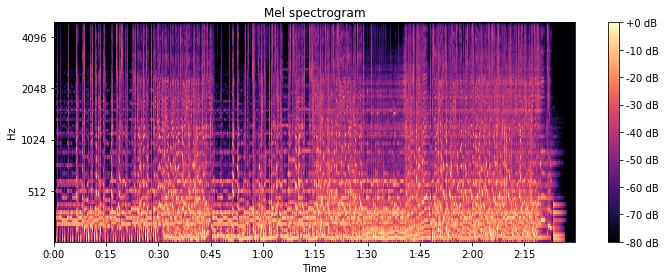

In [16]:
# Create a spectrogram
# From http://cs231n.stanford.edu/reports/2017/pdfs/22.pdf

# More for the LIBROSA packagehttps://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html

%matplotlib inline

import librosa
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# The librosa.display module needs to be explicitly imported (https://github.com/librosa/librosa/issues/441)
import librosa.display


files_location = "/Users/valentin/Documents/MusicEngine/"
song_id = "k3lz248TxUA"

song_path = files_location + "wav/" + song_id + ".wav"

y , sr = librosa.load(song_path, mono = True)

# Create Mel spectrogram
spectogram = librosa.feature.melspectrogram(
    y = y,
    sr = sr,
    n_mels = 128,
    n_fft = 2048,
    hop_length = 1024)

spectogram = librosa.power_to_db(
    spectogram , ref = np.max)

# Plot Mel spectrogram
plt.figure(figsize = (10, 4))
librosa.display.specshow(spectogram,
                         y_axis='mel', fmax = 5000,
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()


In [ ]:
# Create Fourier transformation on the WAV file
# source: https://stackoverflow.com/questions/23377665/python-scipy-fft-wav-files


import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile # get the api

fs, data = wavfile.read("test.wav") # load the data
a = data.T[0] # this is a two channel soundtrack, I get the first track
b = [(ele / 2 ** 8.) * 2 - 1 for ele in a] # this is 8-bit track, b is now normalized on [-1,1)
c = fft(b) # calculate fourier transform (complex numbers list)
d = len(c) / 2  # you only need half of the fft list (real signal symmetry)

plt.plot(abs(c[: (d - 1)]), "r") 
plt.show()


In [9]:
# Extract features from WAV file
# source: https://stackoverflow.com/questions/34742225/how-to-extract-data-from-a-wav-file-using-python-matplotlib-library

""" This work is licensed under a Creative Commons Attribution 3.0 Unported License.
Frank Zalkow, 2012-2013 """

import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac = 0.5, window = np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize / 2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape = (cols, frameSize), strides = (samples.strides[0] * hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    


""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr = 44100, factor = 20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins - 1) / max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale) - 1:
            newspec[:,i] = np.sum(spec[:, scale[i]:], axis = 1)
        else:        
            newspec[:,i] = np.sum(spec[:, scale[i]:scale[i + 1]], axis = 1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins * 2, 1. / sr)[: freqbins + 1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale) - 1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i + 1]])]

    return newspec, freqs


""" plot spectrogram"""
def plotstft(audiopath, binsize = 2 ** 10, plotpath = None, colormap = "jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor = 1.0, sr = samplerate)
    ims = 20. * np.log10(np.abs(sshow) / 10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    plt.figure(figsize = (15, 7.5))
    plt.imshow(np.transpose(ims), origin = "lower", aspect = "auto", cmap = colormap, interpolation = "none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins - 1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins - 1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs * len(samples) / timebins) + (0.5 * binsize)) / samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins - 1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches = "tight")
    else:
        plt.show()

    plt.clf()


plotstft(files_location + "wav/" + song_id + ".wav")

TypeError: 'numpy.float64' object cannot be interpreted as an integer